# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import datetime
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import IntegerType, DateType, StringType, TimestampType, FloatType
from pyspark.sql.functions import desc, udf, isnull, isnan, when, count, col, countDistinct, to_date
from pyspark.sql.functions import sum as Fsum
from py4j.java_gateway import JavaGateway
gateway = JavaGateway()

# import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from pyspark import SparkContext, SparkConf

In [2]:
spark = SparkSession \
    .builder \
    .appName("Music_App") \
    .config("spark.memory.offHeap.enabled", "true") \
    .config("spark.memory.offHeap.size","4g") \
    .getOrCreate()

In [3]:
print( "spark version=" ,SparkSession.builder.appName("test").getOrCreate().version)

spark version= 3.1.2


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [61]:
# path = "mini_sparkify_event_data.json"
path = "sparkify_log_small.json"
data = spark.read.json(path)
data

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [62]:
data.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

In [5]:
def describe_data_cleanup(df, cleanup=0):
    '''
    Display important statistics about the DataFrame before & after data cleanup
    INPUT
        df - spark or pandas DataFrame
        cleanup - String to print ahead of displayed statistics; bool
    OUTPUT
        Print statistics about 'df'
    '''

    if cleanup:
        print(f'Data AFTER clean-up:\n')
    else:
        print(f'Data BEFORE clean-up:\n')
    
    df.printSchema()

    print(f"DataFrame shape:\nrows={df.count()}, columns={len(df.columns)}")
    print(f"Unique userId's = {df.select('userId').dropDuplicates().count()}")
    # print(f"Unique sessionId's = {df.select('sessionId').dropDuplicates().count()}")

    print(f'\nUnique page actions:')
    df.groupBy("page").agg(count("page")).show()

    print(f'\nNull, empty string, nan values per column:')
    df.select([count(when(
        col(c).contains('None') | \
        col(c).contains('NULL') | \
        (col(c) == '' ) | \
        col(c).isNull() | \
        isnan(c), c 
        )).alias(c) for c in df.columns]).show()

def clean_up_data(df):
    '''
    Clean up DataFrame by dropping unused columns & rows that have empty or na values in the specified columns
    INPUT
        df - spark or pandas DataFrame
    OUTPUT
        df_clean - cleaned DataFrame
    '''
    df_clean = df.drop(*[\
        'firstName', 'lastName', 'id_copy', 'auth', 'itemInSession', 'length', \
        'method', 'registration', 'sessionId', 'status', 'userAgent', \
            ])           # drop unused columns 
    df_clean = df_clean.na.drop(how='any', subset=['userId']) #, 'sessionId'])              # drop rows if user or session ID columns contain NA's
    df_clean = df_clean.where((df_clean.userId != "")) # | (df_clean.sessionId != ""))  # drop rows that contain empty strings
    df_clean = df_clean.withColumn("userId", df["userId"].cast(IntegerType()))          # convert userID to integer
    del df
    return df_clean


In [6]:
# Describe data BEFORE cleaning
describe_data_cleanup(data)

Data BEFORE clean-up:

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

DataFrame shape:
rows=54499, columns=18
Unique userId's = 134

Unique page actions:
+--------------------+-----------+
|                page|count(page)|
+--------------------+-----------+
|              Cancel|          9|
|    Submit Downgrade|         17|
|         Thumbs Down| 

In [7]:
# Describe data AFTER cleaning
data_clean = clean_up_data(data)
del data
describe_data_cleanup(data_clean, 1)

Data AFTER clean-up:

root
 |-- artist: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- page: string (nullable = true)
 |-- song: string (nullable = true)
 |-- ts: long (nullable = true)
 |-- userId: integer (nullable = true)

DataFrame shape:
rows=52853, columns=8
Unique userId's = 133

Unique page actions:
+--------------------+-----------+
|                page|count(page)|
+--------------------+-----------+
|              Cancel|          9|
|    Submit Downgrade|         17|
|         Thumbs Down|        421|
|                Home|       2061|
|           Downgrade|        358|
|         Roll Advert|       1004|
|              Logout|        642|
|       Save Settings|         60|
|Cancellation Conf...|          9|
|               About|         76|
|            Settings|        293|
|     Add to Playlist|       1244|
|          Add Friend|        784|
|            NextSong|      43189

In [8]:
data_clean.show(3)

+----------------+------+-----+--------------------+--------+-----------------+-------------+------+
|          artist|gender|level|            location|    page|             song|           ts|userId|
+----------------+------+-----+--------------------+--------+-----------------+-------------+------+
|  Martha Tilston|     M| paid|     Bakersfield, CA|NextSong|        Rockpools|1538352117000|    30|
|Five Iron Frenzy|     M| free|Boston-Cambridge-...|NextSong|           Canada|1538352180000|     9|
|    Adam Lambert|     M| paid|     Bakersfield, CA|NextSong|Time For Miracles|1538352394000|    30|
+----------------+------+-----+--------------------+--------+-----------------+-------------+------+
only showing top 3 rows



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for active users vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [9]:
def value_counts(df, colNames, sorting='ascending'):
    '''
    Count number of occurences per column names.
    INPUT
        df - spark or pandas DataFrame
        colNames - list of column names to group df by
    OUTPUT
        df grouped by colNames
    '''
    if sorting == 'ascending':
        return (df.groupBy(colNames).count().orderBy('count')) #, ascending=True))
    elif sorting == 'descending':
        return (df.groupBy(colNames).count().orderBy(col('count').desc()))
        
def histogram_top_artist(data, rowNum):
    df_counts = value_counts(data, 'artist', 'descending')
    df_counts = df_counts.na.drop("any").limit(rowNum)
    df_counts.show()
    pd_df_counts = df_counts.toPandas()

    plt.figure(figsize=(16, 6), dpi=80)
    # plt.bar(df_counts.select(col('artist')).collect(), df_counts.select(col('count')).collect())
    plt.bar(pd_df_counts['artist'], pd_df_counts['count'])
    plt.title(f'Top {rowNum} artists')
    plt.xlabel('Artist')
    plt.ylabel('Counts')
    plt.xticks(rotation = 45)

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|            Coldplay|  351|
|       Kings Of Leon|  339|
|Florence + The Ma...|  259|
|      The Black Keys|  232|
|       Dwight Yoakam|  217|
|        Jack Johnson|  212|
|            BjÃÂ¶rk|  209|
|       Justin Bieber|  197|
|         The Killers|  190|
|              Eminem|  180|
|                Muse|  178|
|        Taylor Swift|  169|
|     Alliance Ethnik|  165|
|               Train|  164|
|            Harmonia|  161|
|           Radiohead|  150|
|         Linkin Park|  148|
|         Evanescence|  148|
|         OneRepublic|  145|
|          John Mayer|  134|
+--------------------+-----+



c:\Users\kwojn\miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 131 (\x83) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


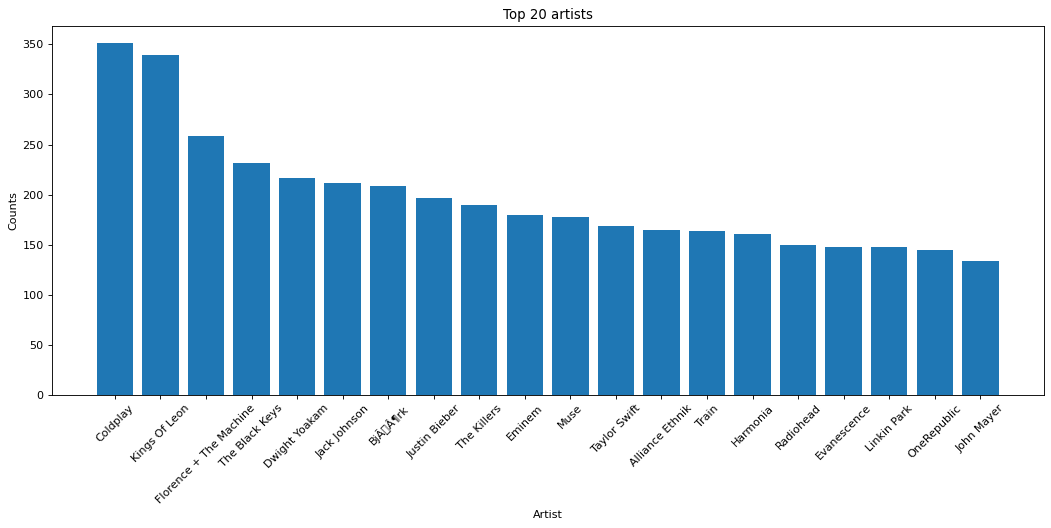

In [11]:
histogram_top_artist(data_clean, 20)

In [12]:
def describe_data_prelim_analysis(df):
    '''
    Display important statistics about the DataFrame 
    INPUT
        df - spark or pandas DataFrame
    OUTPUT
        Print statistics about 'df'
    '''

    print(f"DataFrame shape: \trows={df.count()}, \tcolumns={len(df.columns)}")
    print(f'\nUnique values per column:')
    df.select([countDistinct(col(c)).alias(c) for c in df.columns]).show()

    print(f'\nUnique page actions:')
    df.groupBy("page").agg(count("page")).show(n = df.groupBy("page").agg(count("page")).count() + 1, truncate=False)

def create_churn(df, PageChurnString):
    '''
    Create churn column about DataFrame 
    INPUT
        df - spark or pandas DataFrame
    OUTPUT
        df_churn - df updated with churn rate column 
    '''
    # print(type(df.columns))
    if "churnedEvent" in df.columns:
        flag_downgrade_event = udf(lambda x: 1 if x == PageChurnString else 0, IntegerType())
        df_churn = df.withColumn("churnedEvent", when(col("churnedEvent") == 1, 1).otherwise(flag_downgrade_event("page")))
    else:
        flag_downgrade_event = udf(lambda x: 1 if x == PageChurnString else 0, IntegerType())
        df_churn = df.withColumn("churnedEvent", flag_downgrade_event("page"))

    distinct_churned_users = df_churn.filter(df_churn.churnedEvent == 1).select('userId').distinct()
    list_distinct_churned_users = list(distinct_churned_users.select('userId').toPandas()['userId'])

    df_churn = df_churn.withColumn('churnedUser', when(df_churn.userId.isin(list_distinct_churned_users), 1).otherwise(0)) 

    return df_churn


In [13]:
# Preliminary analysis
describe_data_prelim_analysis(data_clean) 

DataFrame shape: 	rows=52853, 	columns=8

Unique values per column:
+------+------+-----+--------+----+-----+-----+------+
|artist|gender|level|location|page| song|   ts|userId|
+------+------+-----+--------+----+-----+-----+------+
|  9088|     2|    2|      87|  19|21479|51671|   133|
+------+------+-----+--------+----+-----+-----+------+


Unique page actions:
+-------------------------+-----------+
|page                     |count(page)|
+-------------------------+-----------+
|Cancel                   |9          |
|Submit Downgrade         |17         |
|Thumbs Down              |421        |
|Home                     |2061       |
|Downgrade                |358        |
|Roll Advert              |1004       |
|Logout                   |642        |
|Save Settings            |60         |
|Cancellation Confirmation|9          |
|About                    |76         |
|Settings                 |293        |
|Add to Playlist          |1244       |
|Add Friend               |784    

In [14]:
data_churn = create_churn(data_clean, 'Submit Downgrade')
data_churn = create_churn(data_churn, 'Downgrade')
data_churn = create_churn(data_churn, 'Cancellation Confirmation')
# del data_clean

In [15]:
data_churn.show()

+--------------------+------+-----+--------------------+---------------+--------------------+-------------+------+------------+-----------+
|              artist|gender|level|            location|           page|                song|           ts|userId|churnedEvent|churnedUser|
+--------------------+------+-----+--------------------+---------------+--------------------+-------------+------+------------+-----------+
|      Martha Tilston|     M| paid|     Bakersfield, CA|       NextSong|           Rockpools|1538352117000|    30|           0|          1|
|    Five Iron Frenzy|     M| free|Boston-Cambridge-...|       NextSong|              Canada|1538352180000|     9|           0|          1|
|        Adam Lambert|     M| paid|     Bakersfield, CA|       NextSong|   Time For Miracles|1538352394000|    30|           0|          1|
|              Enigma|     M| free|Boston-Cambridge-...|       NextSong|Knocking On Forbi...|1538352416000|     9|           0|          1|
|           Daft Pun

In [16]:
print(f"Number of unique users in dataset = {data_churn.select('userId').distinct().count()}")
print(f"Number of actions in dataset = {data_churn.count()}")
print(f"Number of churned users = {data_churn.filter(data_churn.churnedUser == 1).select('userId').distinct().count()}")
print(f"Number of active users = {data_churn.filter(data_churn.churnedUser == 0).select('userId').distinct().count()}")
print(f"Number of actions associated with churned users = {data_churn.filter(data_churn.churnedUser == 1).count()}")
print(f"Number of actions associated with active users = {data_churn.filter(data_churn.churnedUser == 0).count()}")

Number of unique users in dataset = 133
Number of actions in dataset = 52853
Number of churned users = 59
Number of active users = 74
Number of actions associated with churned users = 42331
Number of actions associated with active users = 10522


In [17]:
print(f'Print example DataFrames with churn column where Page == x:\n')
print(f'Top df row: ')
data_churn.show(1)
print(f'Page == Submit Downgrade: ')
data_churn.filter(data_churn.page == "Submit Downgrade").show(1)
print(f'Page == Downgrade: ')
data_churn.filter(data_churn.page == "Downgrade").show(1)
print(f'Page == Cancellation Confirmation: ')
data_churn.filter(data_churn.page == "Cancellation Confirmation").show(1)

Print example DataFrames with churn column where Page == x:

Top df row: 
+--------------+------+-----+---------------+--------+---------+-------------+------+------------+-----------+
|        artist|gender|level|       location|    page|     song|           ts|userId|churnedEvent|churnedUser|
+--------------+------+-----+---------------+--------+---------+-------------+------+------------+-----------+
|Martha Tilston|     M| paid|Bakersfield, CA|NextSong|Rockpools|1538352117000|    30|           0|          1|
+--------------+------+-----+---------------+--------+---------+-------------+------+------------+-----------+
only showing top 1 row

Page == Submit Downgrade: 
+------+------+-----+--------------------+----------------+----+-------------+------+------------+-----------+
|artist|gender|level|            location|            page|song|           ts|userId|churnedEvent|churnedUser|
+------+------+-----+--------------------+----------------+----+-------------+------+------------+

Observe the behavior for active users vs users who churned. 
- You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [18]:
data_churn.show(3)

+----------------+------+-----+--------------------+--------+-----------------+-------------+------+------------+-----------+
|          artist|gender|level|            location|    page|             song|           ts|userId|churnedEvent|churnedUser|
+----------------+------+-----+--------------------+--------+-----------------+-------------+------+------------+-----------+
|  Martha Tilston|     M| paid|     Bakersfield, CA|NextSong|        Rockpools|1538352117000|    30|           0|          1|
|Five Iron Frenzy|     M| free|Boston-Cambridge-...|NextSong|           Canada|1538352180000|     9|           0|          1|
|    Adam Lambert|     M| paid|     Bakersfield, CA|NextSong|Time For Miracles|1538352394000|    30|           0|          1|
+----------------+------+-----+--------------------+--------+-----------------+-------------+------+------------+-----------+
only showing top 3 rows



In [40]:
def categorical_and_numeric_columns(df):
    '''
    Create list of categorical & numerical columns 
    INPUT
        df - spark or pandas DataFrame
    OUTPUT
        categories_list - list of categorical data
        numerical_list - list of numerical data
    '''


    categories_list = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]
    numerical_list = [f.name for f in df.schema.fields if not isinstance(f.dataType, StringType)]

    # manual updates
    # categories_list.append('status')
    categories_list.remove('location')
    categories_list.remove('artist')
    categories_list.remove('song')
    # categories_list.remove('userAgent')
    categories_list.remove('page')

    print("Categorical data: ", categories_list)
    print("Numerical data: ", numerical_list)
    return categories_list, numerical_list

def number_of_churned_users(df, log_yaxis=False):
    '''
    Plot number of churned vs active users
    INPUT
        df - spark or pandas DataFrame
    OUTPUT
        Plot
    '''

    fig, ax = plt.subplots(figsize=(4, 4))
    fig.suptitle('Number of churned vs active users')

    churned = df.filter(df.churnedUser == 1).select('userId').distinct().count()
    active = df.filter(df.churnedUser == 0).select('userId').distinct().count()
    bars = ax.bar(x = np.array(['churned', 'active']), height=np.array([churned, active]), log=log_yaxis)
    ax.bar_label(bars, label_type='edge')
    ax.set_ylim(None, max(churned, active) * 1.5)

def number_of_churned_user_actions(df, log_yaxis=False):
    '''
    Plot number of actions associated with churned vs active users
    INPUT
        df - spark or pandas DataFrame
    OUTPUT
        Plot
    '''

    fig, ax = plt.subplots(figsize=(4, 4))
    fig.suptitle('Number of actionas associated with churned vs active users')

    churned = df.filter(df.churnedUser == 1).count()
    active = df.filter(df.churnedUser == 0).count()
    bars = ax.bar(x = np.array(['churned', 'active']), height=np.array([churned, active]), log=log_yaxis)
    ax.bar_label(bars, label_type='edge')
    ax.set_ylim(None, max(churned, active) * 1.5)


def create_churned_and_active_lists(cat, pd_value_counts_data, status_unique):
    '''
    Create list of churned and active usercounts from value_counts DataFrame and a specific category. 
    Set count to 0 if no counts available.
    INPUT
        cat - category to define churned vs active counts (ex. "auth")
        pd_value_counts_data - spark or pandas DataFrame grouped by value_counts function
        ex. pd_value_counts_data = 
                    auth  churned  count
                0  Cancelled        1      9
                1  Logged In        1    375
                2  Logged In        0  52469
        status_unique - list of unique values from category column (ex. ['Cancelled', 'Logged In'])
    OUTPUT
        churned_count_list - list of churned user counts for each status_unique value 
        active_count_list - list of active user counts for each status_unique value
    '''

    churned_count_list = []
    active_count_list = []
    for s in status_unique:

        churn_vals = pd_value_counts_data[
            (pd_value_counts_data[cat] == s) & (pd_value_counts_data['churnedUser'] == 1)
            ]['count'].values[0] if len(
                pd_value_counts_data[(pd_value_counts_data[cat] == s) & (pd_value_counts_data['churnedUser'] == 1)]['count']
                ) > 0 else 0

        stay_vals = pd_value_counts_data[
            (pd_value_counts_data[cat] == s) & (pd_value_counts_data['churnedUser'] == 0)
            ]['count'].values[0] if len(
                pd_value_counts_data[(pd_value_counts_data[cat] == s) & (pd_value_counts_data['churnedUser'] == 0)]['count']
                ) > 0 else 0

        churn_vals_count = churn_vals
        stay_vals_count = stay_vals

        if (churn_vals_count == 0) & (stay_vals_count == 0):
            churned_count_list.append(0)
            active_count_list.append(0)

        elif (churn_vals_count == 0) & (stay_vals_count > 0):
            churned_count_list.append(0)
            active_count_list.append(stay_vals)

        elif (churn_vals_count > 0) & (stay_vals_count == 0):
            active_count_list.append(0)
            churned_count_list.append(churn_vals)

        else:
            churned_count_list.append(churn_vals)
            active_count_list.append(stay_vals)

    return churned_count_list, active_count_list

def categorical_data_churn_rate_plots(df, categories):
    '''
    Plot churned vs active user bar plots for each category in list of categorical data columns.
    INPUT
        categories - list of categorical data columns 
        df - spark or pandas DataFrame of all data
    OUTPUT
        Multiple plots
    '''

    fig, axes = plt.subplots(len(categories), figsize=(16, 12))
    fig.suptitle('Categorical data')

    i_idx = 0
    j_idx = 0

    for cat in categories: 

        value_counts_data = value_counts(data_churn, [cat, 'churnedUser'])
        value_counts_data.show()
        pd_value_counts_data = value_counts_data.toPandas()
        cat_unique = value_counts_data.select(cat).distinct().toPandas()[cat].to_list()
        print(cat_unique)
        print(cat)
        print(pd_value_counts_data)

        churned_count_list, active_count_list = create_churned_and_active_lists(cat, pd_value_counts_data, cat_unique)

        # set width of bar
        barWidth = 0.25

        x_arr = cat_unique
        y_arr = churned_count_list

        # Set position of bar on X axis
        x_arr1 = np.arange(len(pd_value_counts_data[cat].unique()))
        # axes[i_idx, j_idx].bar(x = x_arr1, height = y_arr, color='red', log=True, width = barWidth, label ='Churned')
        # axes[i_idx, j_idx].set_title(cat)

        # y_arr = active_count_list
        # x_arr2 = [x + barWidth for x in x_arr1]
        # axes[i_idx, j_idx].bar(x = x_arr2, height = y_arr, color='green', log=True, width = barWidth, label ='Active')

        # # Adding Xticks
        # axes[i_idx, j_idx].set_xlabel(cat, fontweight ='bold', fontsize = 15)
        # axes[i_idx, j_idx].set_ylabel('Frequency', fontweight ='bold', fontsize = 15)
        # axes[i_idx, j_idx].set_xticks([r + barWidth/2 for r in range(len(x_arr1))], cat_unique, rotation = 60, fontsize=12)

        axes[j_idx].bar(x = x_arr1, height = y_arr, color='red', log=True, width = barWidth, label ='Churned')
        axes[j_idx].set_title(cat)

        y_arr = active_count_list
        x_arr2 = [x + barWidth for x in x_arr1]
        axes[j_idx].bar(x = x_arr2, height = y_arr, color='green', log=True, width = barWidth, label ='Active')

        # Adding Xticks
        axes[j_idx].set_xlabel(cat, fontweight ='bold', fontsize = 15)
        axes[j_idx].set_ylabel('Frequency', fontweight ='bold', fontsize = 15)
        axes[j_idx].set_xticks([r + barWidth/2 for r in range(len(x_arr1))], cat_unique, rotation = 60, fontsize=12)
        
        j_idx += 1
        if j_idx > 2:
            j_idx = 0
            i_idx += 1
            
    fig.tight_layout()

def singleCategory_data_churn_rate_plot(df, category):
    '''
    Plot churned vs active users bar plot for a single category in list of categorical data columns.
    INPUT
        category - a categorical data column 
        df - spark or pandas DataFrame of all data
    OUTPUT
        Single plot
    '''

    fig, axes = plt.subplots(figsize=(12, 6))
    fig.suptitle('Categorical data - number of actions for associated churned vs active user')

    value_counts_data = value_counts(data_churn, [category, 'churnedUser'])
    # value_counts_data.show()
    pd_value_counts_data = value_counts_data.toPandas()
    cat_unique = value_counts_data.select(category).distinct().toPandas()[category].to_list()

    churned_count_list, active_count_list = create_churned_and_active_lists(category, pd_value_counts_data, cat_unique)

    # set width of bar
    barWidth = 0.25
    # fig = plt.subplots(figsize =(6, 6))

    x_arr = cat_unique
    y_arr = churned_count_list

    # Set position of bar on X axis
    x_arr1 = np.arange(len(pd_value_counts_data[category].unique()))
    axes.bar(x = x_arr1, height = y_arr, color='red', log=True, width = barWidth, label ='Churned')
    axes.set_title(category)

    y_arr = active_count_list
    x_arr2 = [x + barWidth for x in x_arr1]
    axes.bar(x = x_arr2, height = y_arr, color='green', log=True, width = barWidth, label ='Active')

    # Adding Xticks
    axes.set_xlabel(category, fontweight ='bold', fontsize = 15)
    axes.set_ylabel('Frequency', fontweight ='bold', fontsize = 15)
    axes.set_xticks([r + barWidth/2 for r in range(len(x_arr1))], cat_unique, rotation = 80, fontsize=12)
    axes.legend()

def singleCategory_data_churn_rate_plot_normalize(df, category, log_yaxis=False):
    '''
    Plot churned vs active users bar plot for a single category in list of categorical data columns.
    INPUT
        category - a categorical data column 
        df - spark or pandas DataFrame of all data
    OUTPUT
        Single plot
    '''

    fig, axes = plt.subplots(figsize=(12, 6))
    fig.suptitle('Page data - % of actions vs total churned or active user actions')

    value_counts_data = value_counts(df, [category, 'churnedUser'])
    count_churnedActions = df.filter(df.churnedUser == 1).count()
    count_activeActions = df.filter(df.churnedUser == 0).count()

    value_counts_data = value_counts_data.\
        withColumn('count', when(col("churnedUser") == 1, col("count") / count_churnedActions).otherwise(col("count") / count_activeActions))#.\

    pd_value_counts_data = value_counts_data.toPandas()
    cat_unique = value_counts_data.select(category).distinct().toPandas()[category].to_list()

    churned_count_list, active_count_list = create_churned_and_active_lists(category, pd_value_counts_data, cat_unique)

    # set width of bar
    barWidth = 0.25

    x_arr = cat_unique
    y_arr = churned_count_list

    # Set position of bar on X axis
    x_arr1 = np.arange(len(pd_value_counts_data[category].unique()))
    axes.bar(x = x_arr1, height = y_arr, color='red', log=log_yaxis, width = barWidth, label ='Churned')
    axes.set_title(category)

    y_arr = active_count_list
    x_arr2 = [x + barWidth for x in x_arr1]
    axes.bar(x = x_arr2, height = y_arr, color='green', log=log_yaxis, width = barWidth, label ='active')

    # Adding Xticks
    axes.set_xlabel(category, fontweight ='bold', fontsize = 15)
    axes.set_ylabel('% of all churned or active actions', fontweight ='bold', fontsize = 15)
    axes.set_xticks([r + barWidth/2 for r in range(len(x_arr1))], cat_unique, rotation = 80, fontsize=12)
    axes.legend()

In [41]:
cat_col_list, num_col_list = categorical_and_numeric_columns(data_churn)

Categorical data:  ['gender', 'level']
Numerical data:  ['ts', 'userId', 'churnedEvent', 'churnedUser']


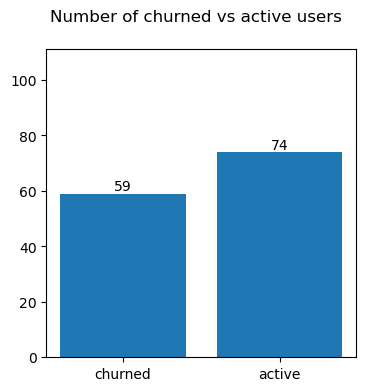

In [28]:
number_of_churned_users(data_churn)

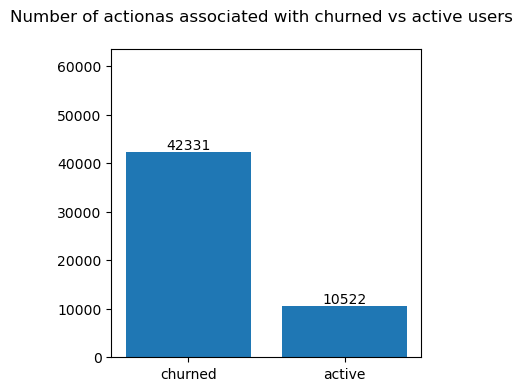

In [29]:
number_of_churned_user_actions(data_churn)

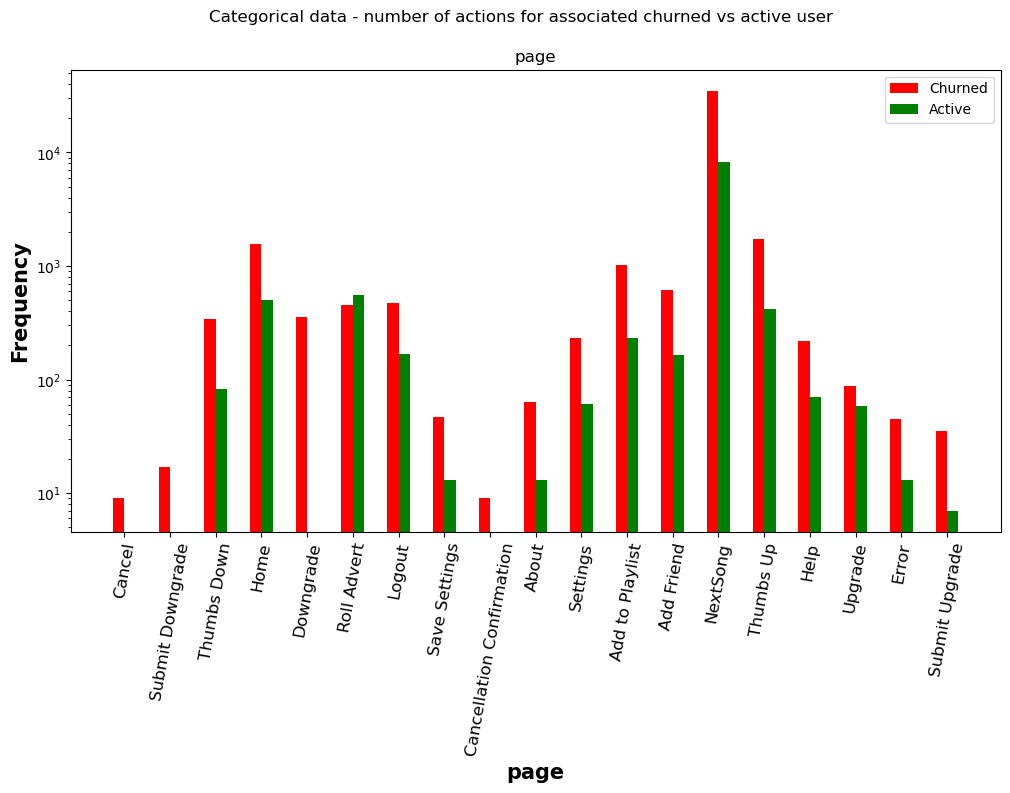

In [30]:
singleCategory_data_churn_rate_plot(data_churn, 'page')

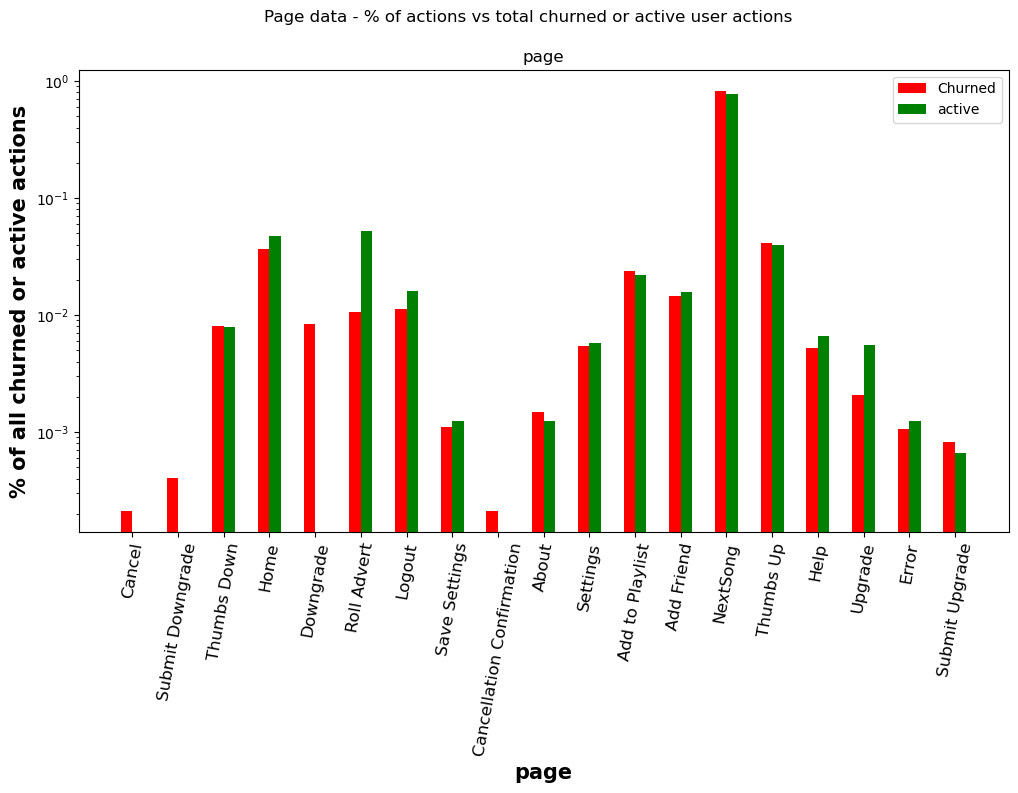

In [31]:
log_yaxis=True
singleCategory_data_churn_rate_plot_normalize(data_churn, 'page', log_yaxis)

In [43]:
print(f'Categories to investigate = {cat_col_list}')

Categories to investigate = ['gender', 'level']


+------+-----------+-----+
|gender|churnedUser|count|
+------+-----------+-----+
|     M|          0| 5125|
|     F|          0| 5397|
|     M|          1|20134|
|     F|          1|22197|
+------+-----------+-----+

['F', 'M']
gender
  gender  churnedUser  count
0      M            0   5125
1      F            0   5397
2      M            1  20134
3      F            1  22197
+-----+-----------+-----+
|level|churnedUser|count|
+-----+-----------+-----+
| paid|          0| 1166|
| free|          1| 7181|
| free|          0| 9356|
| paid|          1|35150|
+-----+-----------+-----+

['free', 'paid']
level
  level  churnedUser  count
0  paid            0   1166
1  free            1   7181
2  free            0   9356
3  paid            1  35150


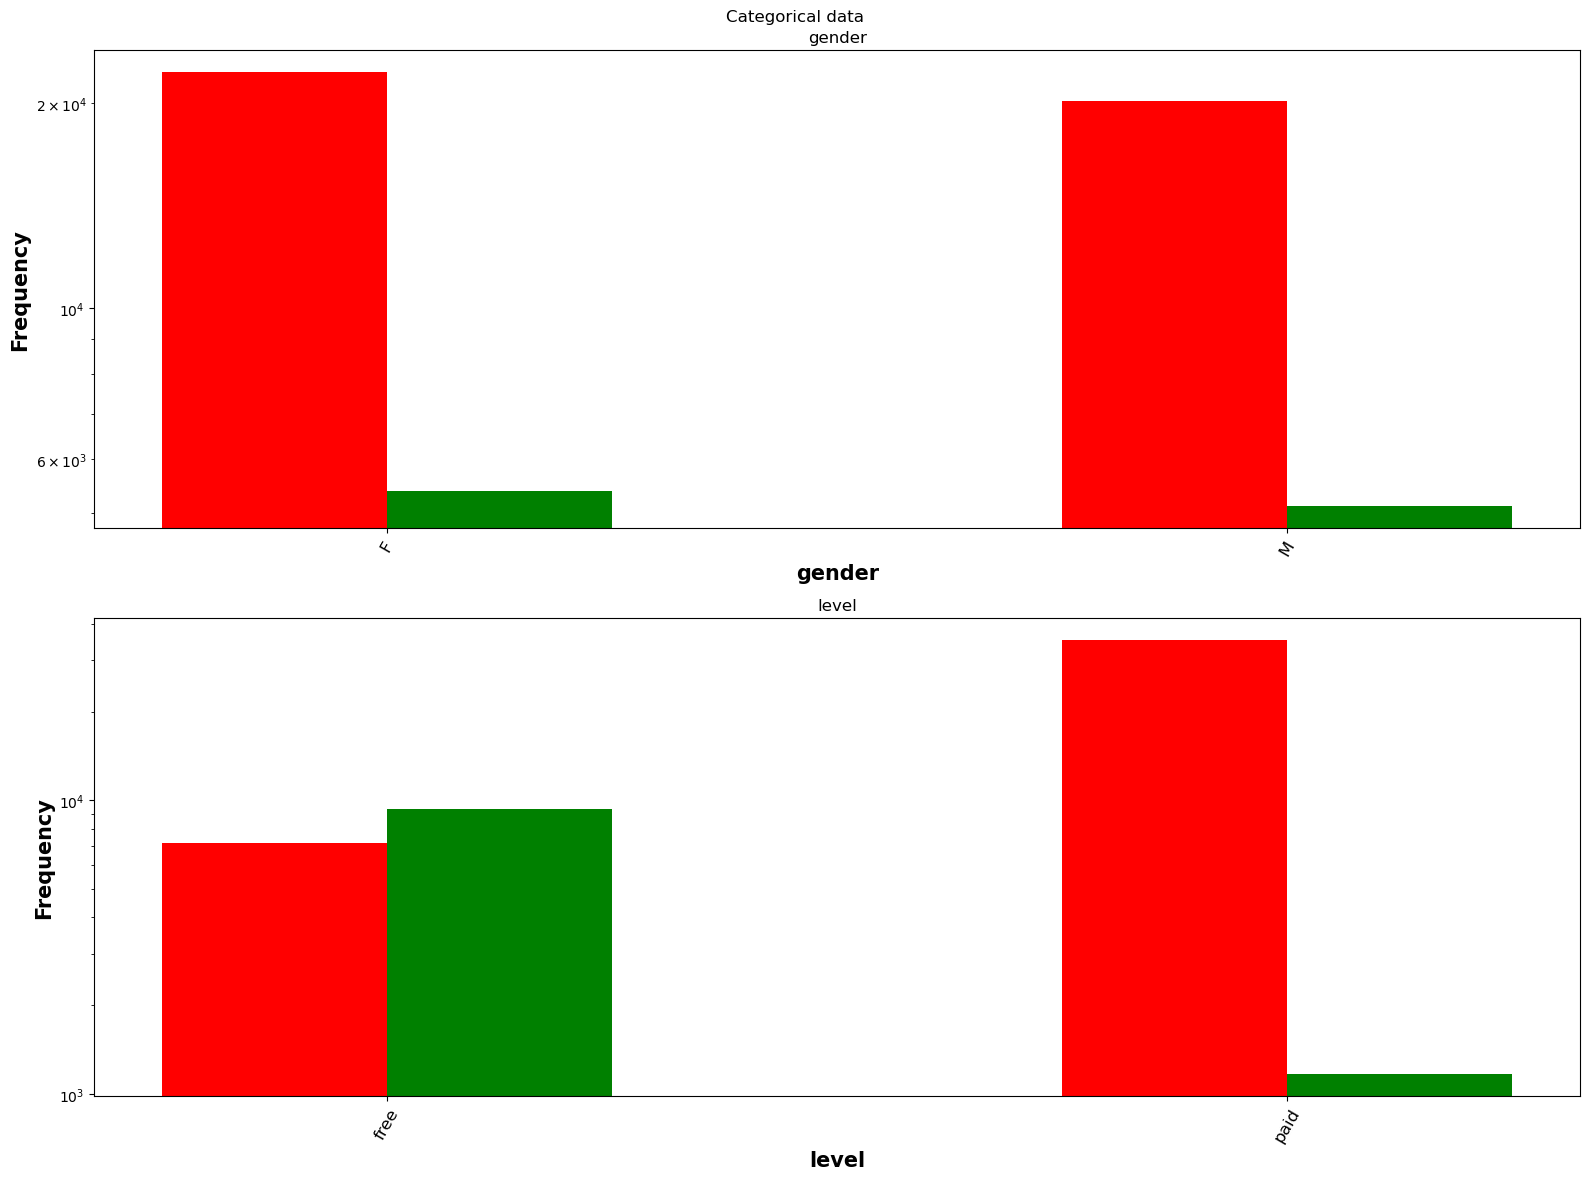

In [44]:
categorical_data_churn_rate_plots(data_churn, cat_col_list)

### You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [45]:
def count_songs_in_hour(df):
    '''
    Count number of songs / rows for a specific hour of the day
    INPUT
        df - spark or pandas DataFrame of all data
    OUTPUT
        df - spark or pandas DataFrame with hour column added
        songs_in_hour - count of songs/rows for a specific hour of the day
    '''
    get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000).hour)
    df = df.withColumn("hour", get_hour(df.ts))
    songs_in_hour = df.filter(df.page == "NextSong").groupby(df.hour).count().orderBy(df.hour.cast("float"))
    return df, songs_in_hour

def create_date_column(df):
    '''
    Convert (ts) timestamp column to datetime & date columns 
    INPUT
        df - spark or pandas DataFrame of all data
    OUTPUT
        df - spark or pandas DataFrame with datetime & date column added
    '''
    get_datetime = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000), TimestampType())
    new_df = df.withColumn("date_time", get_datetime(df.ts))
    
    print(f"Min datetime = \t{new_df.agg({'date_time': 'min'}).collect()[0]}")
    print(f"Max datetime = \t{new_df.agg({'date_time': 'max'}).collect()[0]}")

    # df.withColumn("ts", to_timestamp(col("input_timestamp"))).withColumn("datetype",to_date(col("ts")))
    new_df = new_df.withColumn("date", to_date(col("date_time")))

    return new_df

def plot_number_of_songs_in_each_day_hour(songs_in_hour, usersNames):
    '''
    Plot number of songs played in each day hour
    INPUT
        songs_in_hour - hour & number of songs count table
    OUTPUT
        Single plot
    '''
    songs_in_hour_pd = songs_in_hour.toPandas()
    songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

    fig, axes = plt.subplots(figsize=(12, 6))
    fig.suptitle(f'Songs per hour - UID = {usersNames}')

    axes.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
    axes.set_xlim(-1, 24)
    axes.set_ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
    axes.set_xlabel("Hour")
    axes.set_ylabel("Songs played")

def plot_number_of_songs_in_each_day_hour_churned_vs_active(songs_in_hour_for_churned, songs_in_hour_for_active, usersNames):
    '''
    Plot number of songs played in each day hour
    INPUT
        songs_in_hour - hour & number of songs count table
    OUTPUT
        Single plot
    '''

    fig, axes = plt.subplots(figsize=(12, 6))
    fig.suptitle(f'Songs per hour - UID = {usersNames}')

    songs_in_hour_churned_pd = songs_in_hour_for_churned.toPandas()
    songs_in_hour_churned_pd.hour = pd.to_numeric(songs_in_hour_churned_pd.hour)
    axes.scatter(songs_in_hour_churned_pd["hour"], songs_in_hour_churned_pd["count"], label='churned')

    songs_in_hour_active_pd = songs_in_hour_for_active.toPandas()
    songs_in_hour_active_pd.hour = pd.to_numeric(songs_in_hour_active_pd.hour)
    axes.scatter(songs_in_hour_active_pd["hour"], songs_in_hour_active_pd["count"], label='active')
    
    axes.set_xlim(-1, 24)
    axes.set_ylim(0, 1.2 * max(max(songs_in_hour_churned_pd["count"]), max(songs_in_hour_active_pd["count"])))
    axes.set_xlabel("Hour")
    axes.set_ylabel("Songs played")
    axes.legend()

def concert_timestamp_to_date_time(data_churn):
    # Convert timestamp to date_time
    new_data_churn = create_date_column(data_churn)
    new_data_churn.select('date_time').show(1, truncate = False)
    new_data_churn.select('date').show(1, truncate = False)
    return new_data_churn

def create_cumulative_churn_event_plot(new_data_churn):
    df_w_cumsum = new_data_churn.alias('df_w_cumsum')
    # id(df_w_cumsum) == id(new_data_churn)  # False
    # df_w_cumsum = df_w_cumsum.withColumn("churnedEvent", df_w_cumsum["churnedEvent"].cast(FloatType()))
    # df_w_cumsum = df_w_cumsum.withColumn("churnedUser", df_w_cumsum["churnedUser"].cast(FloatType()))

    windowval = (Window.partitionBy('churnedUser').orderBy('date_time').rangeBetween(Window.unboundedPreceding, 0))
    df_w_cumsum = df_w_cumsum.withColumn('cum_sum', Fsum('churnedEvent').over(windowval))

    plt.figure(figsize=(16, 6), dpi=80)
    plt.scatter(df_w_cumsum.filter(df_w_cumsum.churnedUser == 1).select('date_time').collect(), df_w_cumsum.filter(df_w_cumsum.churnedUser == 1).select('cum_sum').collect(), label='churned')
    # plt.scatter(df_w_cumsum.filter(df_w_cumsum.churnedUser == 0).select('date_time').collect(), df_w_cumsum.filter(df_w_cumsum.churnedUser == 0).select('cum_sum').collect(), label='active')
    plt.title('Churned events cumulative')
    plt.xlabel('Date')
    plt.ylabel('Frequency')
    plt.legend()


Min datetime = 	Row(min(date_time)=datetime.datetime(2018, 10, 1, 2, 1, 57))
Max datetime = 	Row(max(date_time)=datetime.datetime(2018, 10, 17, 9, 8, 36))
+-------------------+
|date_time          |
+-------------------+
|2018-10-01 02:01:57|
+-------------------+
only showing top 1 row

+----------+
|date      |
+----------+
|2018-10-01|
+----------+
only showing top 1 row



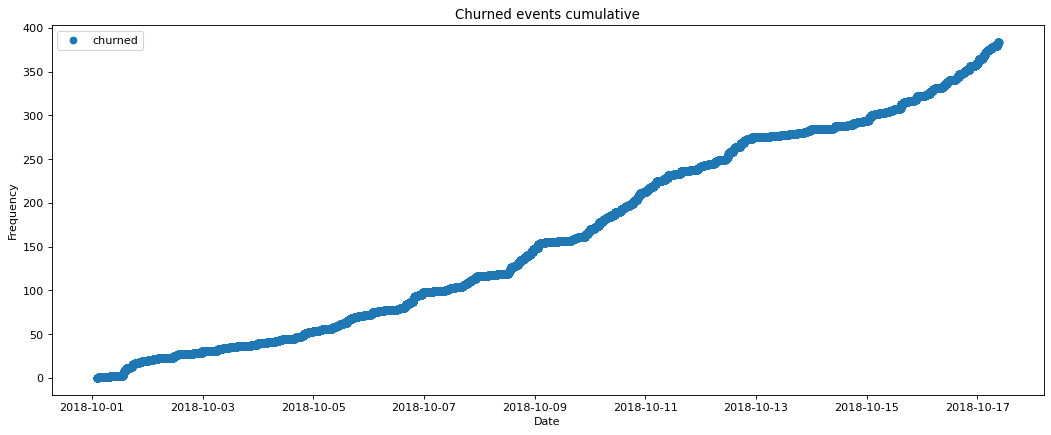

In [46]:
# Convert timestamp to date_time and create a cumulative churned event plot
new_data_churn = concert_timestamp_to_date_time(data_churn)
create_cumulative_churn_event_plot(new_data_churn)


In [47]:
def aggregate_per_day(event):
    return new_data_churn.where(new_data_churn.page == event).groupby('churnedUser', 'date').count().sort('date')

def plot_churned_vs_active(events_perDay, event):
    plt.figure(figsize=(16, 6), dpi=80)
    plt.plot(events_perDay.filter(events_perDay.churnedUser == 1).select('date').collect(), events_perDay.filter(events_perDay.churnedUser == 1).select('count').collect(), label='churned')
    plt.plot(events_perDay.filter(events_perDay.churnedUser == 0).select('date').collect(), events_perDay.filter(events_perDay.churnedUser == 0).select('count').collect(), label='active')
    plt.title(f'Churned vs active users - {event} events per day')
    plt.xlabel('Date')
    plt.ylabel('Frequency')
    plt.legend()

def number_of_events_per_day(new_data_churn, event):
    events_perDay = aggregate_per_day(event)
    plot_churned_vs_active(events_perDay, event)   

In [48]:
# unique_page_events = list(new_data_churn.select(col('page')).distinct().collect())
removeEvents = {'Cancellation Confirmation', 'Downgrade', 'Submit Downgrade'}
unique_page_events = new_data_churn.rdd.map(lambda x: x.page).distinct().collect()
unique_page_events = [ele for ele in unique_page_events if ele not in removeEvents]
unique_page_events


['Thumbs Down',
 'Home',
 'Logout',
 'Help',
 'Settings',
 'About',
 'Error',
 'NextSong',
 'Add to Playlist',
 'Roll Advert',
 'Thumbs Up',
 'Upgrade',
 'Add Friend',
 'Submit Upgrade',
 'Save Settings',
 'Cancel']

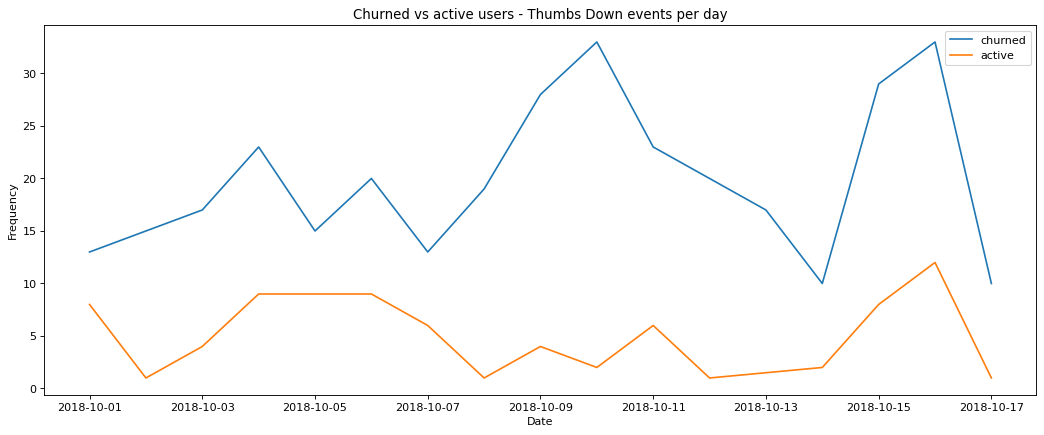

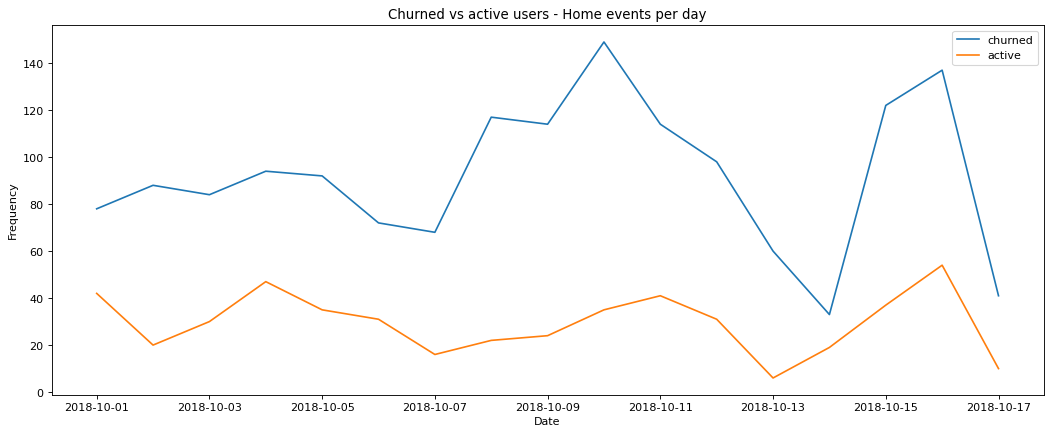

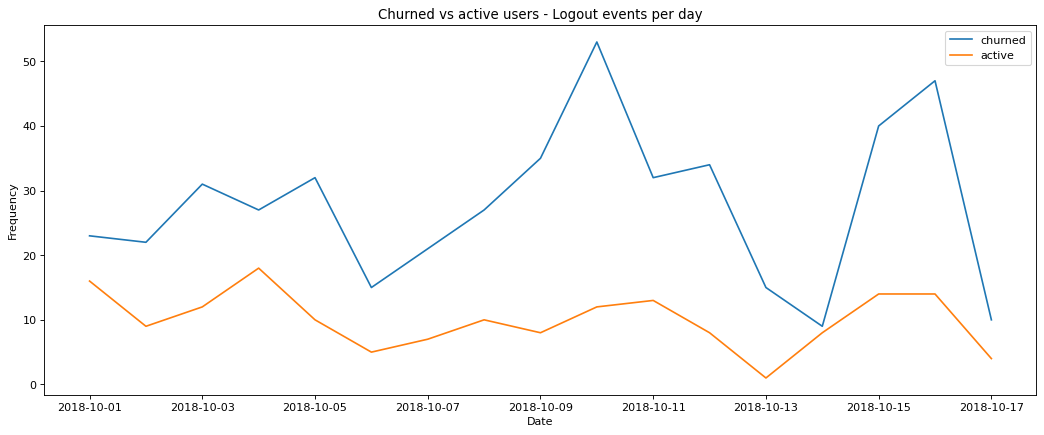

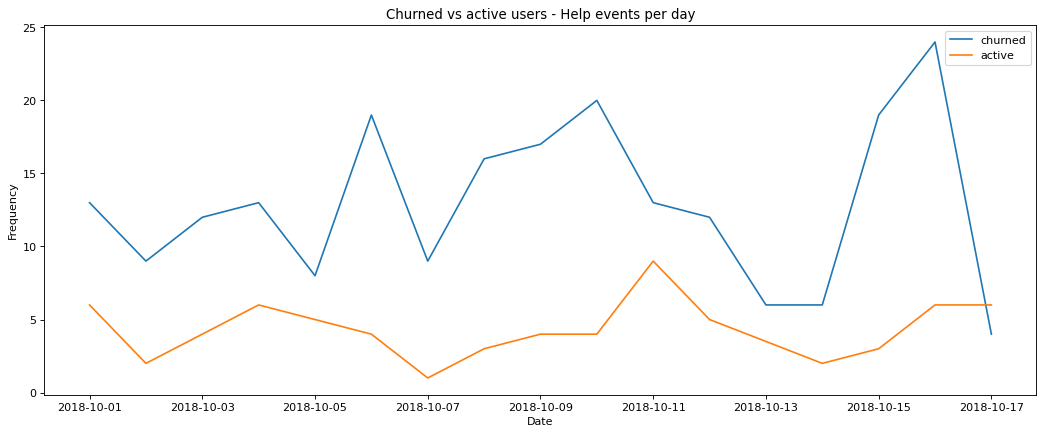

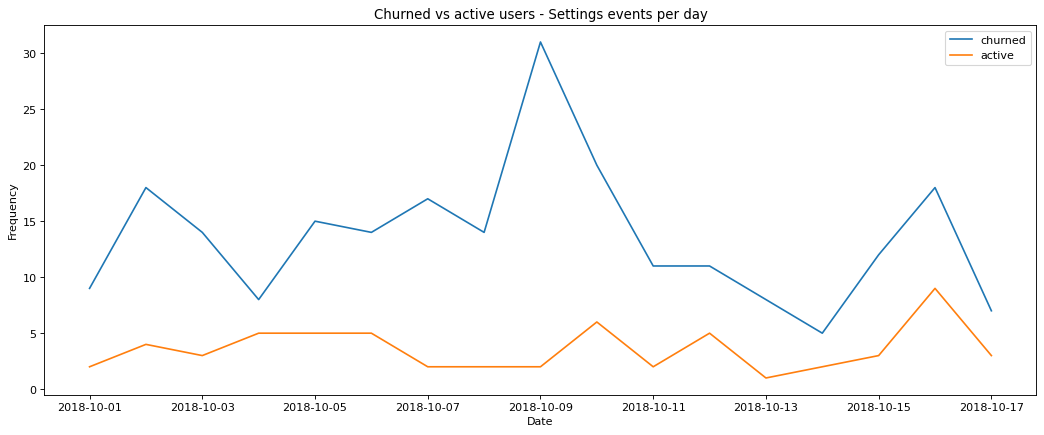

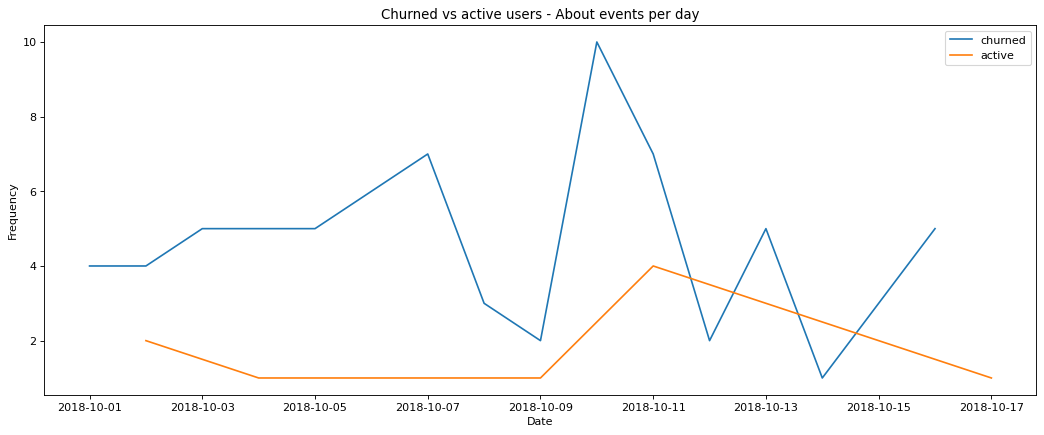

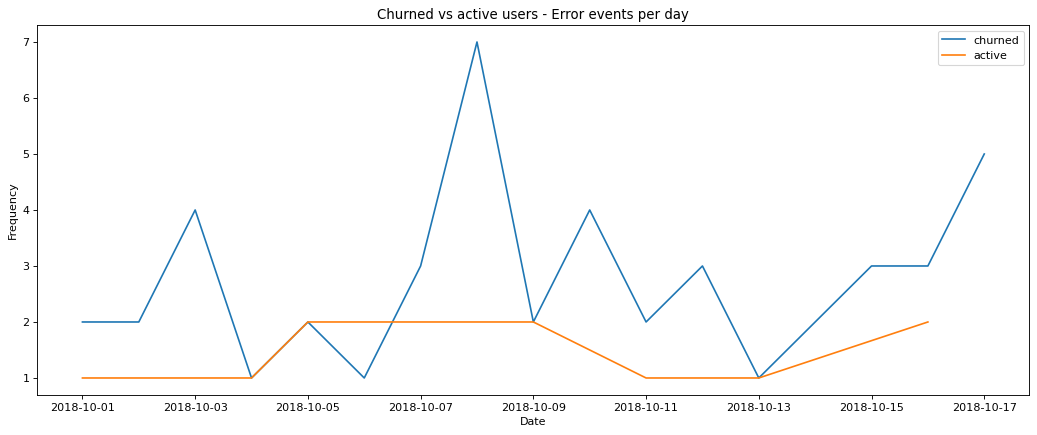

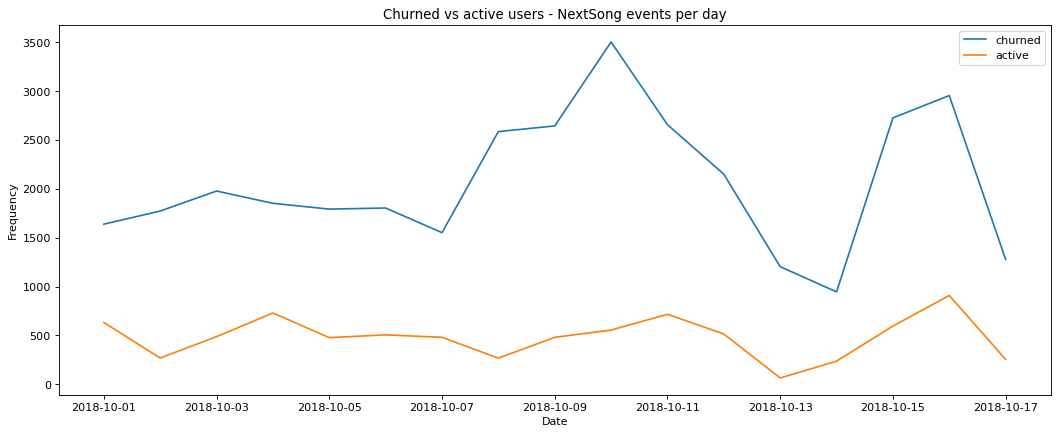

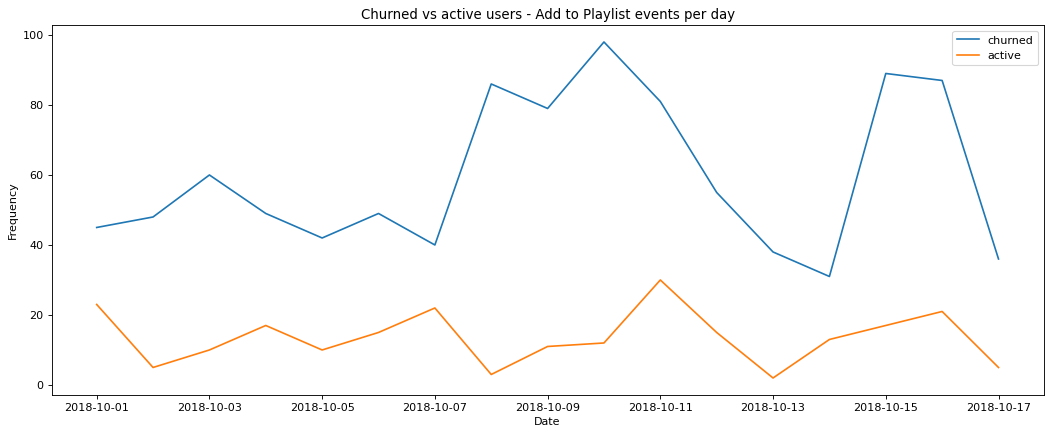

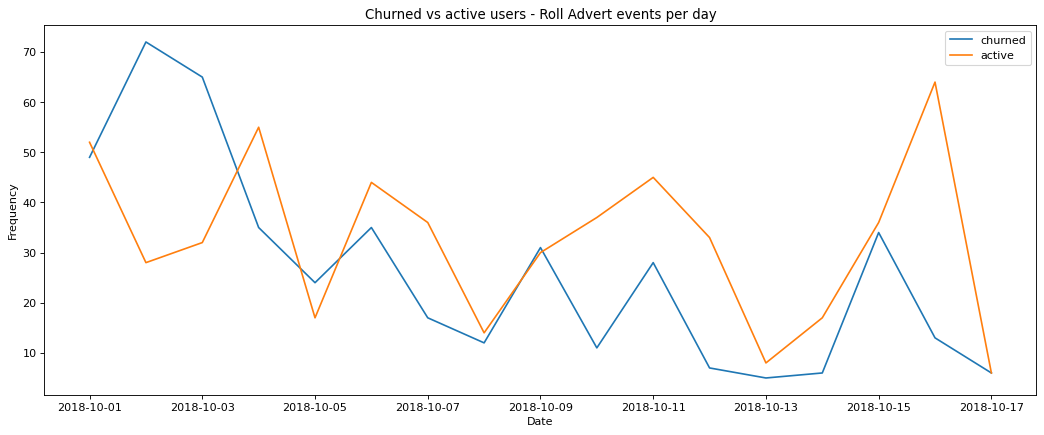

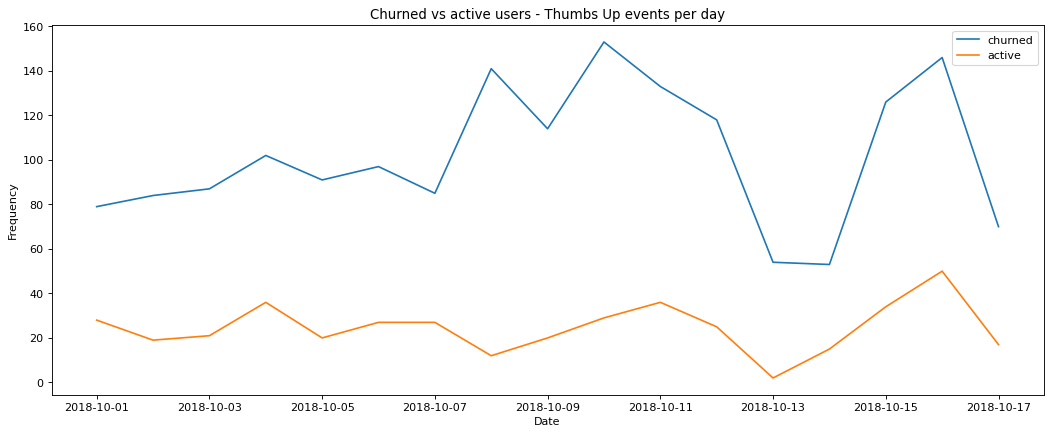

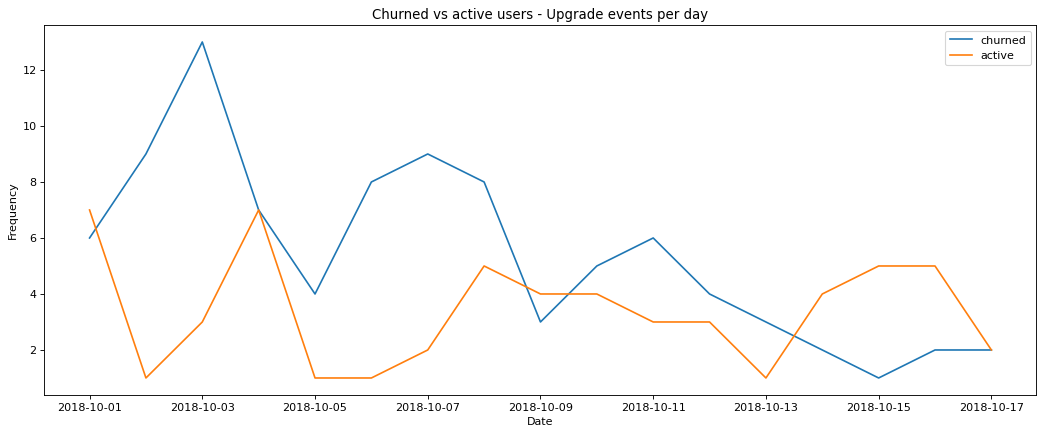

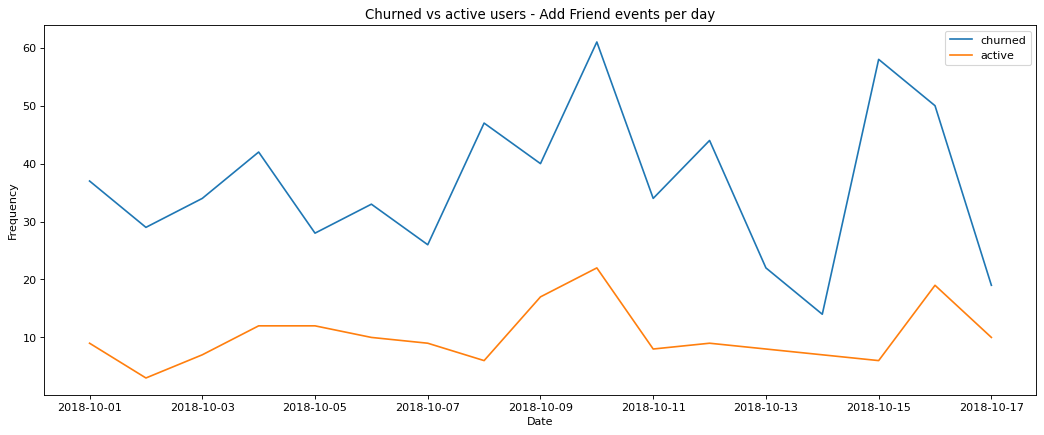

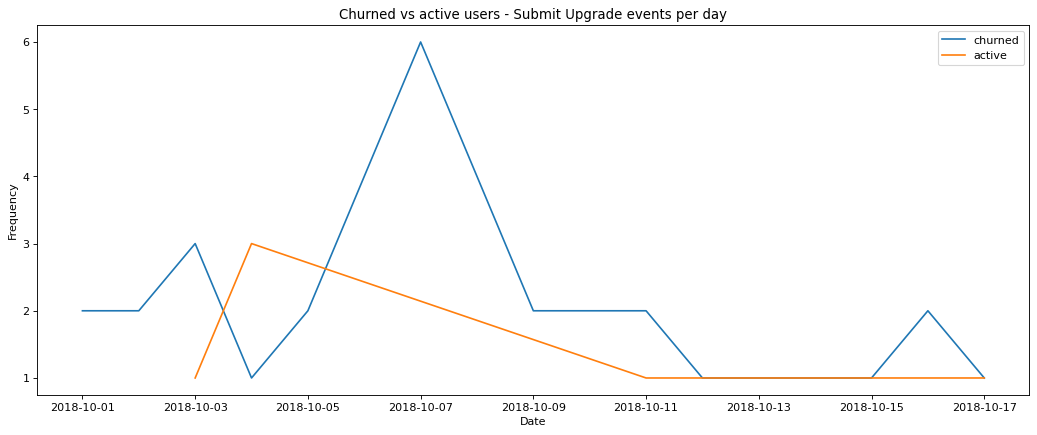

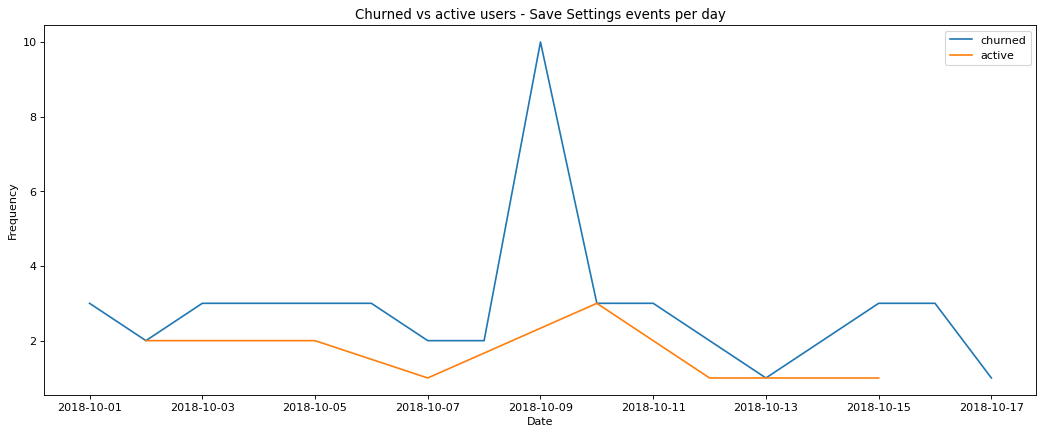

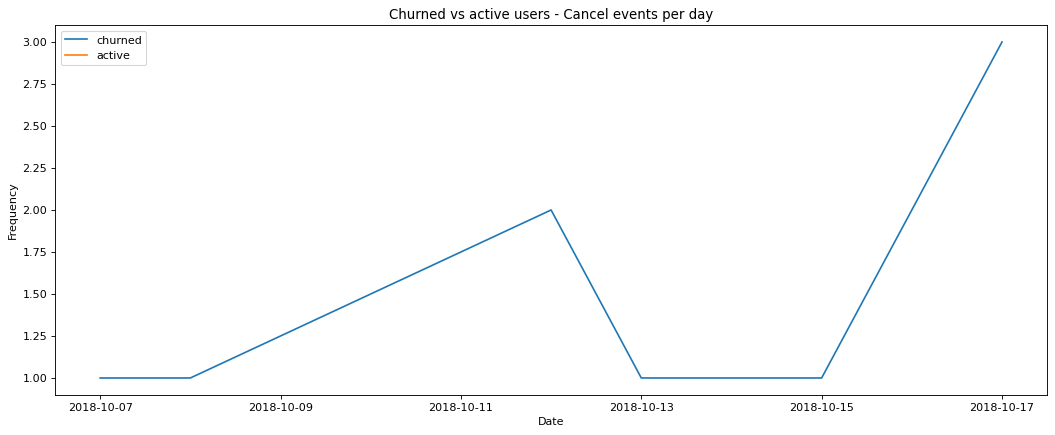

In [49]:
# number_of_songs_played_per_day(new_data_churn)
for pageEvent in unique_page_events:
    number_of_events_per_day(new_data_churn, pageEvent)

In [50]:
data_churn_hours, songs_in_hour = count_songs_in_hour(data_churn)
data_churn_hours.show(3)
songs_in_hour.show(3)

+----------------+------+-----+--------------------+--------+-----------------+-------------+------+------------+-----------+----+
|          artist|gender|level|            location|    page|             song|           ts|userId|churnedEvent|churnedUser|hour|
+----------------+------+-----+--------------------+--------+-----------------+-------------+------+------------+-----------+----+
|  Martha Tilston|     M| paid|     Bakersfield, CA|NextSong|        Rockpools|1538352117000|    30|           0|          1|   2|
|Five Iron Frenzy|     M| free|Boston-Cambridge-...|NextSong|           Canada|1538352180000|     9|           0|          1|   2|
|    Adam Lambert|     M| paid|     Bakersfield, CA|NextSong|Time For Miracles|1538352394000|    30|           0|          1|   2|
+----------------+------+-----+--------------------+--------+-----------------+-------------+------+------------+-----------+----+
only showing top 3 rows

+----+-----+
|hour|count|
+----+-----+
|   0| 1918|
|   1|

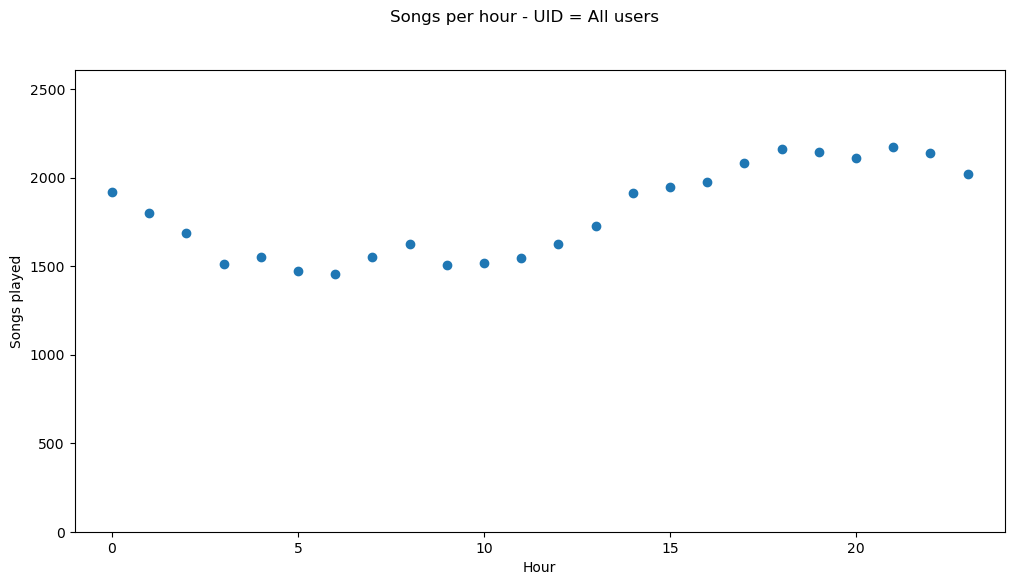

In [51]:
plot_number_of_songs_in_each_day_hour(songs_in_hour, 'All users')

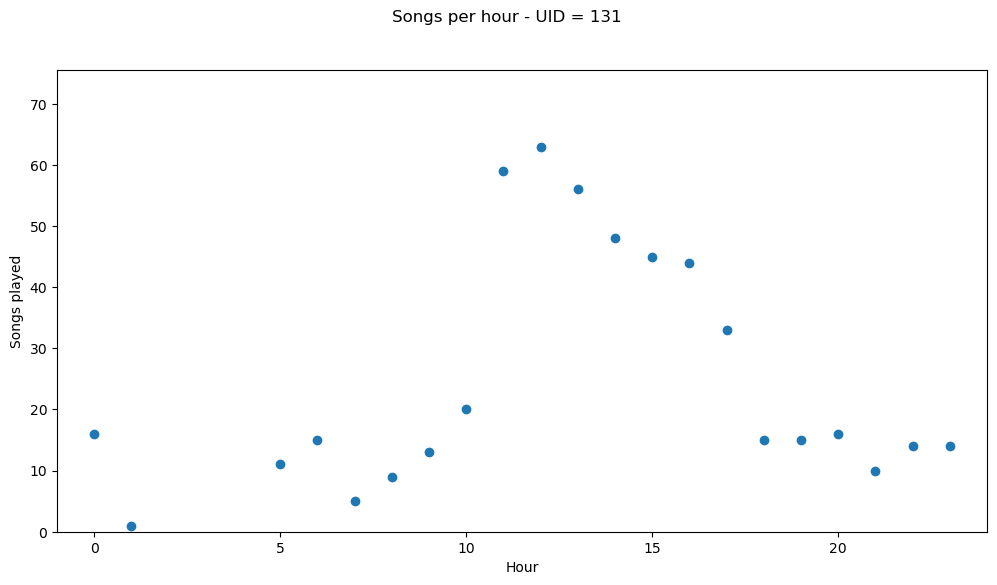

In [52]:
UID = 131 # User ID to create this plot for
_, songs_in_hour_per_user = count_songs_in_hour(data_churn[data_churn.userId == UID])
plot_number_of_songs_in_each_day_hour(songs_in_hour_per_user, UID)

In [53]:
data_churn[data_churn.churnedUser == 1].show()

+--------------------+------+-----+--------------------+---------------+--------------------+-------------+------+------------+-----------+
|              artist|gender|level|            location|           page|                song|           ts|userId|churnedEvent|churnedUser|
+--------------------+------+-----+--------------------+---------------+--------------------+-------------+------+------------+-----------+
|      Martha Tilston|     M| paid|     Bakersfield, CA|       NextSong|           Rockpools|1538352117000|    30|           0|          1|
|    Five Iron Frenzy|     M| free|Boston-Cambridge-...|       NextSong|              Canada|1538352180000|     9|           0|          1|
|        Adam Lambert|     M| paid|     Bakersfield, CA|       NextSong|   Time For Miracles|1538352394000|    30|           0|          1|
|              Enigma|     M| free|Boston-Cambridge-...|       NextSong|Knocking On Forbi...|1538352416000|     9|           0|          1|
|           Daft Pun

+----+-----+
|hour|count|
+----+-----+
|   0| 1546|
|   1| 1494|
|   2| 1418|
|   3| 1254|
|   4| 1282|
+----+-----+
only showing top 5 rows



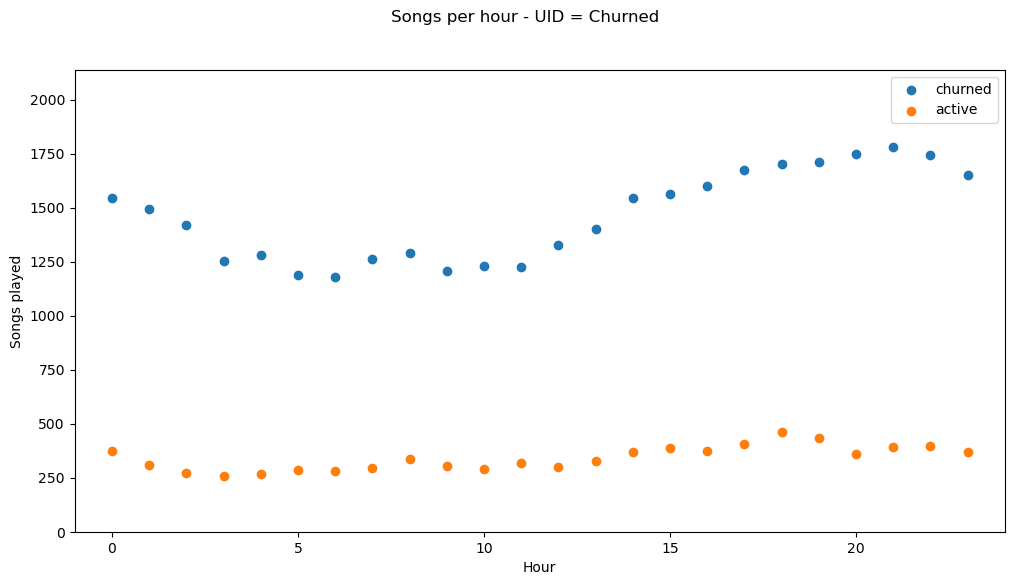

In [54]:
# Users that churned
_, songs_in_hour_for_churned = count_songs_in_hour(data_churn[data_churn.churnedUser == 1])
_, songs_in_hour_for_active = count_songs_in_hour(data_churn[data_churn.churnedUser == 0])
songs_in_hour_for_churned.show(5)
plot_number_of_songs_in_each_day_hour_churned_vs_active(songs_in_hour_for_churned, songs_in_hour_for_active, 'Churned')

In [55]:
data_churn_hours.select(["userId", "page", "hour"]).where(data_churn_hours.userId == 131).collect()

[Row(userId=131, page='NextSong', hour='10'),
 Row(userId=131, page='NextSong', hour='11'),
 Row(userId=131, page='NextSong', hour='11'),
 Row(userId=131, page='NextSong', hour='11'),
 Row(userId=131, page='NextSong', hour='11'),
 Row(userId=131, page='NextSong', hour='11'),
 Row(userId=131, page='NextSong', hour='11'),
 Row(userId=131, page='NextSong', hour='11'),
 Row(userId=131, page='NextSong', hour='11'),
 Row(userId=131, page='NextSong', hour='11'),
 Row(userId=131, page='NextSong', hour='11'),
 Row(userId=131, page='NextSong', hour='11'),
 Row(userId=131, page='NextSong', hour='11'),
 Row(userId=131, page='NextSong', hour='11'),
 Row(userId=131, page='NextSong', hour='12'),
 Row(userId=131, page='NextSong', hour='12'),
 Row(userId=131, page='NextSong', hour='12'),
 Row(userId=131, page='NextSong', hour='12'),
 Row(userId=131, page='Add to Playlist', hour='12'),
 Row(userId=131, page='NextSong', hour='12'),
 Row(userId=131, page='NextSong', hour='12'),
 Row(userId=131, page='Help

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [89]:
data_features = data_churn.alias('data_features')
data_features = data_features.drop("artist", "location", "song", "userId", "churnedEvent", "churnedUser")
data_features.show()

+------+-----+---------------+-------------+
|gender|level|           page|           ts|
+------+-----+---------------+-------------+
|     M| paid|       NextSong|1538352117000|
|     M| free|       NextSong|1538352180000|
|     M| paid|       NextSong|1538352394000|
|     M| free|       NextSong|1538352416000|
|     M| paid|       NextSong|1538352676000|
|     M| free|       NextSong|1538352678000|
|     M| free|       NextSong|1538352886000|
|     M| paid|       NextSong|1538352899000|
|     M| paid|Add to Playlist|1538352905000|
|     M| paid|       NextSong|1538353084000|
|     M| free|       NextSong|1538353146000|
|     M| free|    Roll Advert|1538353150000|
|     M| paid|       NextSong|1538353218000|
|     M| free|       NextSong|1538353375000|
|     M| free|      Thumbs Up|1538353376000|
|     M| paid|       NextSong|1538353441000|
|     M| free|       NextSong|1538353576000|
|     F| free|       NextSong|1538353668000|
|     M| paid|       NextSong|1538353687000|
|     M| f

In [90]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.functions import vector_to_array
import pyspark.sql.functions as F

indexer = StringIndexer(inputCol='gender', outputCol='male')
indexer_fitted = indexer.fit(data_features)
data_features = indexer_fitted.transform(data_features)
data_features = data_features.drop("gender")

indexer = StringIndexer(inputCol='level', outputCol='level_paid')
indexer_fitted = indexer.fit(data_features)
data_features = indexer_fitted.transform(data_features)
data_features = data_features.drop("level")

data_features.show()

+---------------+-------------+----+----------+
|           page|           ts|male|level_paid|
+---------------+-------------+----+----------+
|       NextSong|1538352117000| 1.0|       0.0|
|       NextSong|1538352180000| 1.0|       1.0|
|       NextSong|1538352394000| 1.0|       0.0|
|       NextSong|1538352416000| 1.0|       1.0|
|       NextSong|1538352676000| 1.0|       0.0|
|       NextSong|1538352678000| 1.0|       1.0|
|       NextSong|1538352886000| 1.0|       1.0|
|       NextSong|1538352899000| 1.0|       0.0|
|Add to Playlist|1538352905000| 1.0|       0.0|
|       NextSong|1538353084000| 1.0|       0.0|
|       NextSong|1538353146000| 1.0|       1.0|
|    Roll Advert|1538353150000| 1.0|       1.0|
|       NextSong|1538353218000| 1.0|       0.0|
|       NextSong|1538353375000| 1.0|       1.0|
|      Thumbs Up|1538353376000| 1.0|       1.0|
|       NextSong|1538353441000| 1.0|       0.0|
|       NextSong|1538353576000| 1.0|       1.0|
|       NextSong|1538353668000| 0.0|    

In [91]:
indexer = StringIndexer(inputCol='page', outputCol='page_numeric')
indexer_fitted = indexer.fit(data_features)
data_features = indexer_fitted.transform(data_features)
data_features = data_features.drop("page")

encoder = OneHotEncoder(inputCols=['page_numeric'], outputCols=['page_onehot'])
data_features = encoder.fit(data_features).transform(data_features)
data_features = data_features.drop("page_numeric")

data_features = data_features.select('*', vector_to_array('page_onehot').alias('col_onehot'))
data_features = data_features.drop("page_onehot")

# num_categories = len(data_features.first()['col_onehot'])
# cols_expanded = [(F.col('col_onehot')[i]) for i in range(num_categories)]
# data_features = data_features.select('*', *cols_expanded)

num_categories = len(data_features.first()['col_onehot'])   # 3
cols_expanded = [(F.col('col_onehot')[i].alias(f'page_{indexer_fitted.labels[i]}')) for i in range(num_categories)]
data_features = data_features.select('*', *cols_expanded)
data_features = data_features.drop("col_onehot")
data_features.show()

+-------------+----+----------+-------------+--------------+---------+--------------------+----------------+---------------+-----------+----------------+--------------+-------------+---------+------------+----------+------------------+----------+-------------------+---------------------+-----------+
|           ts|male|level_paid|page_NextSong|page_Thumbs Up|page_Home|page_Add to Playlist|page_Roll Advert|page_Add Friend|page_Logout|page_Thumbs Down|page_Downgrade|page_Settings|page_Help|page_Upgrade|page_About|page_Save Settings|page_Error|page_Submit Upgrade|page_Submit Downgrade|page_Cancel|
+-------------+----+----------+-------------+--------------+---------+--------------------+----------------+---------------+-----------+----------------+--------------+-------------+---------+------------+----------+------------------+----------+-------------------+---------------------+-----------+
|1538352117000| 1.0|       0.0|          1.0|           0.0|      0.0|                 0.0|      

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.